# С задачей оттока я хорошо знаком по работе в Билайне, мы с коллегами из АТ Консалтинг "пилили" модель для Вымпелкома для определения В2С оттока.

## Целевое событие определялось следующим образом:
>1. Выбираем абонентов которые активны в течении 4 недель подряд.
2. Среди них ищем клиентов, которые после этих 4 недель становятся неактивными в течении 4 недель.
3. **Активный абонент** - абонент, который совершает исходящие звонки, в течении недели, либо отправляет СМС, либо есть исходящий/входящий дата-трафик.
4. Обучались на исторических данных, проверяли на смещенных.
5. Целевое событие составило около 0.5%
6. Метрика - Lift, хотели получить высокий лифт на 0.1%. Т.е. скорим 4 000 000, получаем 4000 наиболее вероятных отточников.
7. Lift на 0.1% составил около 90. Т.е. из 4 000 абонентов, которых мы отдавали в результирующей выборке каждую неделю, около 1800 были реально отточниками.
8. В качестве входных данных использовались дневные агрегаты из DATAMART, на основе которых создавались витрины в Оракле. Основне выстреливающие фичи - LifeTime, резкое падение трафика в последние недели.

In [1463]:
import pandas as pd
%matplotlib inline
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.combine import SMOTEENN 

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

# Read Data

#### Считываем данные:

In [1464]:
df = pd.read_csv('telco-customer-churn.csv')
#df = df.drop(['noadditionallines','callingnum','year'], axis=1)
#df = pd.read_csv('AfterDE.csv')
#df = df.drop(['noadditionallines','callingnum'], axis=1)
#df = pd.read_csv('for_make.csv')
df.iloc[0:4]

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,maritalstatus,monthlybilledamount,noadditionallines,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,occupation,penaltytoswitch,state,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
0,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,Single,71,\N,0,7,96,Technology Related Job,371,WA,15,19,No,No,0.82,5971,663,0,2015,1
1,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,Single,71,\N,0,7,96,Technology Related Job,371,WA,15,19,No,No,0.82,3981,995,0,2015,2
2,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,Single,8,\N,1,4,14,Technology Related Job,43,WI,212,34,No,Yes,0.27,7379,737,0,2015,1
3,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,Single,8,\N,1,4,14,Technology Related Job,43,WI,212,34,No,Yes,0.27,1729,432,0,2015,2


#### Удаляем 'noadditionallines','callingnum','year' т.к. они не несут никакой информации.
callingnum - номер телефона

In [1465]:
df = df.drop(['noadditionallines','callingnum','year'], axis=1)

In [1466]:
print(df.shape[0], ' - size of observation')
print(df.shape[1], ' - size of prediction')

20468  - size of observation
26  - size of prediction


# Сколько наблюдаемых абонентов в каждом месяце?

In [1467]:
df_1m = df[df['month']==1]
df_2m = df[df['month']==2]
df_3m = df[df['month']==3]
print (df[df['month']==1].shape[0], ' - Count abonents in 1 month')
print (df[df['month']==2].shape[0], ' - Count abonents in 2 month')
print (df[df['month']==3].shape[0], ' - Count abonents in 3 month')

9475  - Count abonents in 1 month
9466  - Count abonents in 2 month
1527  - Count abonents in 3 month


In [1468]:
df_customer_id = df[['customerid','month']].groupby(['customerid'], as_index=False).count()
tmp_col = ['customerid','month_count']
df_customer_id.columns = tmp_col
df = df.merge(df_customer_id)
print (int(df[df['month_count']==1].shape[0]), ' - Abonents having 1 month')
print (int(df[df['month_count']==2].shape[0]/2), ' - Abonents having 2 month')
print (int(df[df['month_count']==3].shape[0]/3), ' - Abonents having 3 month')
print('---------------------------------')
df_1 = df[df['month_count']==1]
df_2 = df[df['month_count']==2]
df_3 = df[df['month_count']==3]
print(len(df_1))
print(len(df_2)/2)
print(len(df_3)/3)
print('---------------------------------')
#df = df.set_index(['customerid'])
print('Целевое событие среди абонентов которые имелись в наблюдении в течении одного месяца')
print (100*df_1.churn.value_counts()/df_1.shape[0])
print('Целевое событие среди абонентов которые имелись в наблюдении в течении двух месяцев')
print (100*df_2.churn.value_counts()/df_2.shape[0])
print('Целевое событие среди абонентов которые имелись в наблюдении в течении трех месяцев')
print (100*df_3.churn.value_counts()/df_3.shape[0])
print('Целевое событие общее')
print (100*df.churn.value_counts()/df.shape[0])
print('---------------------------------')

95  - Abonents having 1 month
7917  - Abonents having 2 month
1513  - Abonents having 3 month
---------------------------------
95
7917.0
1513.0
---------------------------------
Целевое событие среди абонентов которые имелись в наблюдении в течении одного месяца
0    90.526316
1     9.473684
Name: churn, dtype: float64
Целевое событие среди абонентов которые имелись в наблюдении в течении двух месяцев
0    91.133005
1     8.866995
Name: churn, dtype: float64
Целевое событие среди абонентов которые имелись в наблюдении в течении трех месяцев
0    90.085922
1     9.914078
Name: churn, dtype: float64
Целевое событие общее
0    90.897987
1     9.102013
Name: churn, dtype: float64
---------------------------------


### Далее я залил таблицу в базу данных, закинул данные сделал три витрины:
**mtsgeneral** = *(SELECT age, annualincome, calldroprate, callfailurerate, callingnum, customerid, customersuspended, education, gender, homeowner, maritalstatus, monthlybilledamount, noadditionallines, numberofcomplaints, numberofmonthunpaid, 
numdayscontractequipmentplanexpiring, occupation, penaltytoswitch, state, totalminsusedinlastmonth, unpaidbalance, usesinternetservice, usesvoiceservice, percentagecalloutsidenetwork, churn, COUNT(*) *AS cnt
FROM dbo.Churn
GROUP BY age, annualincome, calldroprate, callfailurerate, callingnum, customerid, customersuspended, education, gender, homeowner, maritalstatus, monthlybilledamount, noadditionallines, numberofcomplaints, numberofmonthunpaid, 
numdayscontractequipmentplanexpiring, occupation, penaltytoswitch, state, totalminsusedinlastmonth, unpaidbalance, usesinternetservice, usesvoiceservice, percentagecalloutsidenetwork, churn)*


**mtsmonth1** = *SELECT customerid, totalcallduration AS totalcallduration_1, avgcallduration AS avgcallduration_1
FROM     dbo.Churn
WHERE  (month = '1')

**mtsmonth2** = *SELECT customerid, totalcallduration AS totalcallduration_2, avgcallduration AS avgcallduration_3
FROM     dbo.Churn
WHERE  (month = '2')

**mtsmonth3** = *SELECT customerid, totalcallduration AS totalcallduration_3, avgcallduration AS avgcallduration_3
FROM     dbo.Churn
WHERE  (month = '3')

### Далее заджойнил к первой витрине три следующих при помощи левого внешнего соединения.

 **select * from mtsgeneral a
left join
mtsmonth1 b
on a.customerid = b.customerid
left join
mtsmonth2 c
on a.customerid = c.customerid
left join
mtsmonth3 d
on a.customerid = d.customerid**

### Сохранил и заново считал.

In [1469]:
#df = pd.read_csv('telco-customer-churn.csv')
#df = df.drop(['noadditionallines','callingnum','year'], axis=1)
df = pd.read_csv('AfterDE.csv')
#df = df.drop(['noadditionallines','callingnum'], axis=1)
#df = pd.read_csv('for_make.csv')
df.iloc[0:4]

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,maritalstatus,monthlybilledamount,noadditionallines,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,occupation,penaltytoswitch,state,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,churn,cnt,totalcallduration_1,avgcallduration_1,totalcallduration_2,avgcallduration_2,totalcallduration_3,avgcallduration_3,1_month,2_month,3_month
0,12,18243,0.01,0.03,4251055343,9483,Yes,Master or equivalent,Female,Yes,Single,36,\N,1,4,59,Technology Related Job,378,VA,446,192,No,No,0.78,0,2,1963.0,654.0,3789.0,473.0,NaN,NaN,1,1,0
1,12,214547,0.04,0.03,166477265,469,Yes,High School or below,Male,Yes,Single,94,\N,3,2,15,Others,305,TX,483,189,No,No,0.23,0,2,2760.0,552.0,1308.0,436.0,NaN,NaN,1,1,0
2,13,44205,0.00,0.00,4251059354,3204,Yes,Bachelor or equivalent,Male,Yes,Married,1,\N,0,6,96,Others,211,IA,199,160,No,No,0.14,0,2,2366.0,788.0,2412.0,482.0,NaN,NaN,1,1,0
3,13,216760,0.06,0.00,4251084493,3020,Yes,Master or equivalent,Male,Yes,Single,18,\N,2,0,25,Others,220,PA,173,182,No,No,0.84,0,2,3885.0,647.0,1951.0,975.0,NaN,NaN,1,1,0


In [1470]:
print(df.shape[0], ' - size of observation')
print(df.shape[1], ' - size of prediction')

9525  - size of observation
35  - size of prediction


In [1471]:
print('Целевое событие общее')
print (100*df.churn.value_counts()/df.shape[0])
print('---------------------------------')
df.dtypes

Целевое событие общее
0    90.96063
1     9.03937
Name: churn, dtype: float64
---------------------------------


age                                       int64
annualincome                              int64
calldroprate                            float64
callfailurerate                         float64
callingnum                                int64
customerid                                int64
customersuspended                        object
education                                object
gender                                   object
homeowner                                object
maritalstatus                            object
monthlybilledamount                       int64
noadditionallines                        object
numberofcomplaints                        int64
numberofmonthunpaid                       int64
numdayscontractequipmentplanexpiring      int64
occupation                               object
penaltytoswitch                           int64
state                                    object
totalminsusedinlastmonth                  int64
unpaidbalance                           

In [1472]:
df.isnull().any()

age                                     False
annualincome                            False
calldroprate                            False
callfailurerate                         False
callingnum                              False
customerid                              False
customersuspended                       False
education                               False
gender                                  False
homeowner                               False
maritalstatus                           False
monthlybilledamount                     False
noadditionallines                       False
numberofcomplaints                      False
numberofmonthunpaid                     False
numdayscontractequipmentplanexpiring    False
occupation                              False
penaltytoswitch                         False
state                                   False
totalminsusedinlastmonth                False
unpaidbalance                           False
usesinternetservice               

In [1473]:
df = df.fillna(0)

In [1474]:
df = df.drop(['noadditionallines','callingnum'], axis=1)

## Feature Eng

#### Avgcall Relation between 1,2,3 months

In [1475]:
df['avgcall_1_2'] = df['avgcallduration_1']/df['avgcallduration_2']
df['avgcall_2_3'] = df['avgcallduration_2']/df['avgcallduration_3']
df['avgcall_1_3'] = df['avgcallduration_1']/df['avgcallduration_3']

#### Part of month avgcall in general sum

In [1476]:
df['avgcall_1_123'] = df['avgcallduration_1']/(df['avgcallduration_1']+df['avgcallduration_2'] + df['avgcallduration_3'])
df['avgcall_2_123'] = df['avgcallduration_2']/(df['avgcallduration_1']+df['avgcallduration_2'] + df['avgcallduration_3'])
df['avgcall_3_123'] = df['avgcallduration_3']/(df['avgcallduration_1']+df['avgcallduration_2'] + df['avgcallduration_3'])

#### Sum

In [1477]:
df['avgcall_123'] = (df['avgcallduration_1']+df['avgcallduration_2'] + df['avgcallduration_3'])
df['avgcall_123'] = (df['avgcallduration_1']+df['avgcallduration_2'] + df['avgcallduration_3'])
df['avgcall_123'] = (df['avgcallduration_1']+df['avgcallduration_2'] + df['avgcallduration_3'])

#### Part of month totalcall in general sum

In [1478]:
df['totalcall_1_2'] = df['totalcallduration_1']/df['totalcallduration_2']
df['totalcall_2_3'] = df['totalcallduration_2']/df['totalcallduration_3']
df['totalcall_1_3'] = df['totalcallduration_1']/df['totalcallduration_3']

#### Part of month totalcall in general sum

In [1479]:
df['totalcall_1_2_123'] = df['totalcallduration_1']/(df['totalcallduration_1']+df['totalcallduration_2']+df['totalcallduration_3'])
df['totalcall_2_3_123'] = df['totalcallduration_2']/(df['totalcallduration_1']+df['totalcallduration_2']+df['totalcallduration_3'])
df['totalcall_1_3_123'] = df['totalcallduration_3']/(df['totalcallduration_1']+df['totalcallduration_2']+df['totalcallduration_3'])

#### Sum

In [1480]:
df['totalcall_123'] = (df['totalcallduration_1']+df['totalcallduration_2']+df['totalcallduration_3'])
df['totalcall_123'] = (df['totalcallduration_1']+df['totalcallduration_2']+df['totalcallduration_3'])
df['totalcall_123'] = (df['totalcallduration_1']+df['totalcallduration_2']+df['totalcallduration_3'])

In [1481]:
print(len(df.customerid.unique()), ' - Число уникальных абонентов')
#print(len(df.callingnum.unique()), ' - Число уникальных абонентов')

9525  - Число уникальных абонентов


In [1482]:
%matplotlib inline
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.combine import SMOTEENN 

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score


# Check null

In [1483]:
df = df.fillna(0)
df = df.replace([np.inf, -np.inf], 0)
#df.isnull().any()
df.dtypes

age                                       int64
annualincome                              int64
calldroprate                            float64
callfailurerate                         float64
customerid                                int64
customersuspended                        object
education                                object
gender                                   object
homeowner                                object
maritalstatus                            object
monthlybilledamount                       int64
numberofcomplaints                        int64
numberofmonthunpaid                       int64
numdayscontractequipmentplanexpiring      int64
occupation                               object
penaltytoswitch                           int64
state                                    object
totalminsusedinlastmonth                  int64
unpaidbalance                             int64
usesinternetservice                      object
usesvoiceservice                        

# Data Describe / Data Describe(churn)

In [1484]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,9525.0,45.358320,19.616188,12.0,28.000000,45.000000,62.000000,79.000000
annualincome,9525.0,124675.519055,72182.704410,4.0,62233.000000,124637.000000,187388.000000,249987.000000
calldroprate,9525.0,0.035027,0.023008,0.0,0.010000,0.040000,0.060000,0.070000
callfailurerate,9525.0,0.015229,0.011215,0.0,0.010000,0.020000,0.030000,0.030000
customerid,9525.0,4763.000000,2749.774991,1.0,2382.000000,4763.000000,7144.000000,9525.000000
monthlybilledamount,9525.0,59.632546,34.653617,0.0,29.000000,60.000000,90.000000,119.000000
numberofcomplaints,9525.0,1.502047,1.118607,0.0,1.000000,2.000000,3.000000,3.000000
numberofmonthunpaid,9525.0,3.495223,2.290189,0.0,2.000000,3.000000,5.000000,7.000000
numdayscontractequipmentplanexpiring,9525.0,49.392861,28.899349,0.0,24.000000,49.000000,74.000000,99.000000
penaltytoswitch,9525.0,248.951076,144.153548,0.0,125.000000,249.000000,373.000000,499.000000


In [1485]:
churn_summary = df.groupby('churn')
q = churn_summary.mean().T
q

churn,0,1
age,46.188596,37.003484
annualincome,124748.878693,123937.321719
calldroprate,0.034976,0.035540
callfailurerate,0.015209,0.015436
customerid,4761.580563,4777.283391
monthlybilledamount,59.510503,60.860627
numberofcomplaints,1.482225,1.701510
numberofmonthunpaid,3.490189,3.545877
numdayscontractequipmentplanexpiring,49.541551,47.896632
penaltytoswitch,249.004848,248.409988


### Age variable importance

In [1486]:
age_population = df.age.mean()
age_fraud = df[df.churn == 1].age.mean()
print('mean  of Age: {}, mean  of Age: {}'.format(age_population, age_fraud))
import scipy.stats as stats
stats.ttest_1samp(df[df['churn']==1]['age'], df[df['churn']==0]['age'].mean())

mean  of Age: 45.358320209973755, mean  of Age: 37.00348432055749


Ttest_1sampResult(statistic=-14.828974629701406, pvalue=1.8107939927706564e-44)

In [1487]:
#for i in range(len(list(df.columns))):
#    print(stats.ttest_1samp(df[df['churn']==1][list(df.columns)[i]], df[df['churn']==0][list(df.columns)[i]].mean()),list(df.columns)[i])

Text(0.5,1,'Age distribution - churn V.S. no churn')

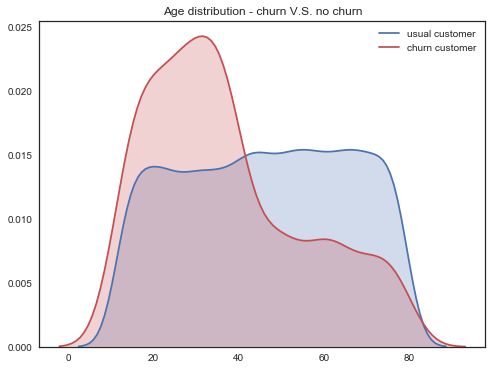

In [1488]:
fig = plt.figure(figsize=(8,6),)
ax=sns.kdeplot(df.loc[(df['churn'] == 0), 'age'] , color='b', shade=True,label='usual customer')
ax=sns.kdeplot(df.loc[(df['churn'] == 1), 'age'] , color='r', shade=True, label='churn customer')
plt.title('Age distribution - churn V.S. no churn')

### Видим что большинство отточников, люди до 40 лет. Т.е. портрет отточника - молодой человек моложе 40 лет / Age - очень важная переменная

In [1391]:
#fig = plt.figure(figsize=(16,4),)
#ax=sns.kdeplot(df.loc[(df['churn'] == 0), 'avgcallduration'] , color='b', shade=True,label='usual customer')
#ax=sns.kdeplot(df.loc[(df['churn'] == 1), 'avgcallduration'] , color='r', shade=True, label='churn customer')
#print (plt.title('Avgcallduration distribution - churn V.S. no churn'))

In [1392]:
#cat_columns = list(df.select_dtypes(['uint8']).columns)
#df.dtypes

In [1393]:
#cat_columns = list(df.select_dtypes(['int64']).columns)
#for i in range(len(cat_columns)):
#    fig = plt.figure(figsize=(6,4),)
#    ax=sns.kdeplot(df.loc[(df['churn'] == 0), cat_columns[i]] , color='b', shade=True,label='usual customer')
#    ax=sns.kdeplot(df.loc[(df['churn'] == 1), cat_columns[i]] , color='r', shade=True, label='churn customer')
#    plt.title(cat_columns[i])

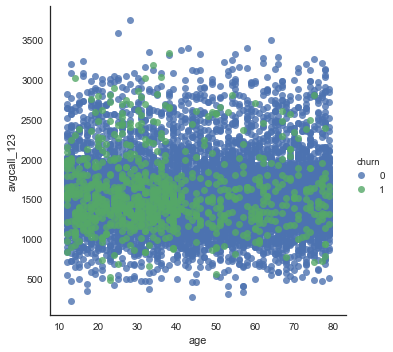

In [1489]:
sns.lmplot(x='age', y='avgcall_123', data=df,
           fit_reg=False, # No regression line
           hue='churn')   # Color by evolution stage

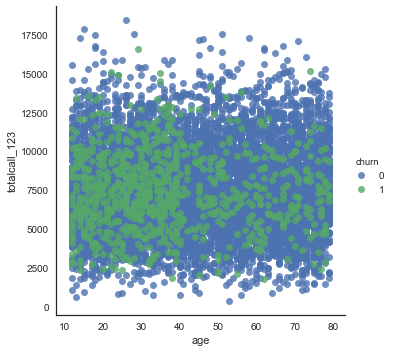

In [1490]:
sns.lmplot(x='age', y='totalcall_123', data=df,
           fit_reg=False, # No regression line
           hue='churn')   # Color by evolution stage

In [1491]:
#cat_columns = df.select_dtypes(['int64']).columns
#cat_columns = ['age','churn']
#sns.pairplot(df.loc[:, list(cat_columns)], hue='churn')

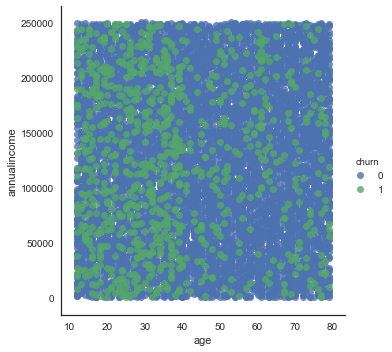

In [1492]:
sns.lmplot(x='age', y='annualincome', data=df,
           fit_reg=False, # No regression line
           hue='churn')   # Color by evolution stage

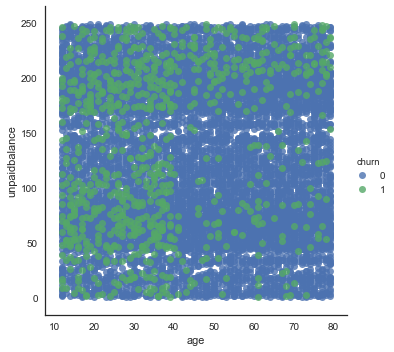

In [1493]:
sns.lmplot(x='age', y='unpaidbalance', data=df,
           fit_reg=False, # No regression line
           hue='churn')   # Color by evolution stage

In [1494]:
df.head()

,age,annualincome,calldroprate,callfailurerate,customerid,customersuspended,education,gender,homeowner,maritalstatus,monthlybilledamount,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,occupation,penaltytoswitch,state,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,churn,cnt,totalcallduration_1,avgcallduration_1,totalcallduration_2,avgcallduration_2,totalcallduration_3,avgcallduration_3,1_month,2_month,3_month,avgcall_1_2,avgcall_2_3,avgcall_1_3,avgcall_1_123,avgcall_2_123,avgcall_3_123,avgcall_123,totalcall_1_2,totalcall_2_3,totalcall_1_3,totalcall_1_2_123,totalcall_2_3_123,totalcall_1_3_123,totalcall_123
0,12,18243,0.01,0.03,9483,Yes,Master or equivalent,Female,Yes,Single,36,1,4,59,Technology Related Job,378,VA,446,192,No,No,0.78,0,2,1963.0,654.0,3789.0,473.0,0.0,0.0,1,1,0,1.382664,0.0,0.0,0.580302,0.419698,0.0,1127.0,0.518079,0.0,0.0,0.341273,0.658727,0.0,5752.0
1,12,214547,0.04,0.03,469,Yes,High School or below,Male,Yes,Single,94,3,2,15,Others,305,TX,483,189,No,No,0.23,0,2,2760.0,552.0,1308.0,436.0,0.0,0.0,1,1,0,1.266055,0.0,0.0,0.558704,0.441296,0.0,988.0,2.110092,0.0,0.0,0.678466,0.321534,0.0,4068.0
2,13,44205,0.00,0.00,3204,Yes,Bachelor or equivalent,Male,Yes,Married,1,0,6,96,Others,211,IA,199,160,No,No,0.14,0,2,2366.0,788.0,2412.0,482.0,0.0,0.0,1,1,0,1.634855,0.0,0.0,0.620472,0.379528,0.0,1270.0,0.980929,0.0,0.0,0.495186,0.504814,0.0,4778.0
3,13,216760,0.06,0.00,3020,Yes,Master or equivalent,Male,Yes,Single,18,2,0,25,Others,220,PA,173,182,No,No,0.84,0,2,3885.0,647.0,1951.0,975.0,0.0,0.0,1,1,0,0.663590,0.0,0.0,0.398890,0.601110,0.0,1622.0,1.991287,0.0,0.0,0.665696,0.334304,0.0,5836.0
4,14,7780,0.00,0.03,2416,Yes,PhD or equivalent,Male,Yes,Married,86,1,7,23,Others,158,CO,479,79,No,No,0.84,0,2,3238.0,647.0,3116.0,1038.0,0.0,0.0,1,1,0,0.623314,0.0,0.0,0.383976,0.616024,0.0,1685.0,1.039153,0.0,0.0,0.509600,0.490400,0.0,6354.0


# Попробуем гет-дами, encoding дал качество хуже

# Categorial Dat Encoding

In [1400]:
## Кодирование значений
def catEncoder(series, nCats=0):
    ## Количество значений, которые необходимо закодировать-это такие уникальные значения, процент встречаемости которых >2%, 
    ## не считая самого популярного значения
    
    nCats = series.value_counts()[(series.value_counts()/(series.value_counts().sum() -
                                  series.value_counts()[0]-series.value_counts()[1])> 0.002)].shape[0]
    return dict([(x, i) for i, x in enumerate(series.value_counts().index[:nCats])])

In [1401]:
def readEncodTables(df, isTrain=True, encodersDict=None):
    
    
    for col in df.select_dtypes(include=['object']).columns:
        if 'NOT_IND' in df[col].value_counts():
#            print(col)
            df[col] = df[col].replace('NOT_IND', np.nan).astype(float)

    
    if not encodersDict:

        encoders = dict()
        for key in df.dtypes[df.dtypes.map(str).isin(['int', 'float', 'bool', 'int64', 'float64','datetime64[ns]']) == False].index:
            
            encoders[key] = catEncoder(df[key], 0)
    else:

        encoders = encodersDict
        
    
    for key in encoders:
        df[key] = df[key].fillna('Nodata')
        df[key] = df[key].map(encoders[key])
        df[key] = df[key].fillna(-1)
        
    
    return df, encoders

In [1402]:
df, encoders = readEncodTables(df)

In [1403]:
df.head()
df.head()

,age,annualincome,calldroprate,callfailurerate,customerid,customersuspended,education,gender,homeowner,maritalstatus,monthlybilledamount,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,occupation,penaltytoswitch,state,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,churn,cnt,totalcallduration_1,avgcallduration_1,totalcallduration_2,avgcallduration_2,totalcallduration_3,avgcallduration_3,1_month,2_month,3_month,avgcall_1_2,avgcall_2_3,avgcall_1_3,avgcall_1_123,avgcall_2_123,avgcall_3_123,avgcall_123,totalcall_1_2,totalcall_2_3,totalcall_1_3,totalcall_1_2_123,totalcall_2_3_123,totalcall_1_3_123,totalcall_123
0,12,18243,0.01,0.03,9483,0,2,0,0,0,36,1,4,59,2,378,25,446,192,0,0,0.78,0,2,1963.0,654.0,3789.0,473.0,0.0,0.0,1,1,0,1.382664,0.0,0.0,0.580302,0.419698,0.0,1127.0,0.518079,0.0,0.0,0.341273,0.658727,0.0,5752.0
1,12,214547,0.04,0.03,469,0,0,1,0,0,94,3,2,15,0,305,16,483,189,0,0,0.23,0,2,2760.0,552.0,1308.0,436.0,0.0,0.0,1,1,0,1.266055,0.0,0.0,0.558704,0.441296,0.0,988.0,2.110092,0.0,0.0,0.678466,0.321534,0.0,4068.0
2,13,44205,0.00,0.00,3204,0,1,1,0,1,1,0,6,96,0,211,23,199,160,0,0,0.14,0,2,2366.0,788.0,2412.0,482.0,0.0,0.0,1,1,0,1.634855,0.0,0.0,0.620472,0.379528,0.0,1270.0,0.980929,0.0,0.0,0.495186,0.504814,0.0,4778.0
3,13,216760,0.06,0.00,3020,0,2,1,0,0,18,2,0,25,0,220,12,173,182,0,0,0.84,0,2,3885.0,647.0,1951.0,975.0,0.0,0.0,1,1,0,0.663590,0.0,0.0,0.398890,0.601110,0.0,1622.0,1.991287,0.0,0.0,0.665696,0.334304,0.0,5836.0
4,14,7780,0.00,0.03,2416,0,3,1,0,1,86,1,7,23,0,158,14,479,79,0,0,0.84,0,2,3238.0,647.0,3116.0,1038.0,0.0,0.0,1,1,0,0.623314,0.0,0.0,0.383976,0.616024,0.0,1685.0,1.039153,0.0,0.0,0.509600,0.490400,0.0,6354.0


# Get_Dummies

In [1495]:
df = pd.get_dummies(df)

# Histogram

# Drop columns / Set indexes

In [1496]:
#df = df.drop(['month','month_count'], axis=1)
#df = df.set_index('customerid')

#df = df.drop(['month','month_count'], axis=1)
df = df.set_index('customerid')

# Get statistict group by Churn

In [1497]:
fraud_summary = df.groupby('churn')
q = fraud_summary.mean().T
q

churn,0,1
age,46.188596,37.003484
annualincome,124748.878693,123937.321719
calldroprate,0.034976,0.035540
callfailurerate,0.015209,0.015436
monthlybilledamount,59.510503,60.860627
numberofcomplaints,1.482225,1.701510
numberofmonthunpaid,3.490189,3.545877
numdayscontractequipmentplanexpiring,49.541551,47.896632
penaltytoswitch,249.004848,248.409988
totalminsusedinlastmonth,249.555979,251.576074


# Correlation

In [1498]:
CorrKoef = df.corr()
CorField985 = []
print ('----- 2.1 Correlations')
print ('cor |field| > .9')
for i in CorrKoef:
    for j in CorrKoef.index[(CorrKoef[i] > 0.9) | (CorrKoef[i] < -0.9)]:
        if i != j and j not in CorField985 and i not in CorField985:
            CorField985.append(j)
            print ("%s-->%s: r^2=%f" % (i,j, CorrKoef[i][CorrKoef.index==j].values[0]))
print ('CorField985', len(CorField985))

----- 2.1 Correlations
cor |field| > .9
cnt-->3_month: r^2=0.960280
totalcallduration_3-->avgcallduration_3: r^2=0.961981
totalcallduration_3-->avgcall_3_123: r^2=0.948103
totalcallduration_3-->totalcall_1_3_123: r^2=0.928047
avgcall_2_3-->avgcall_1_3: r^2=0.980787
avgcall_2_3-->totalcall_2_3: r^2=0.981695
avgcall_2_3-->totalcall_1_3: r^2=0.982666
totalcall_1_2_123-->totalcall_2_3_123: r^2=-0.968616
customersuspended_No-->customersuspended_Yes: r^2=-1.000000
gender_Female-->gender_Male: r^2=-1.000000
homeowner_No-->homeowner_Yes: r^2=-1.000000
maritalstatus_Married-->maritalstatus_Single: r^2=-1.000000
usesinternetservice_No-->usesinternetservice_Yes: r^2=-1.000000
usesvoiceservice_No-->usesvoiceservice_Yes: r^2=-1.000000
CorField985 14


### Correlation vizualization

Text(0.5,1,'Heatmap of Correlation Matrix')

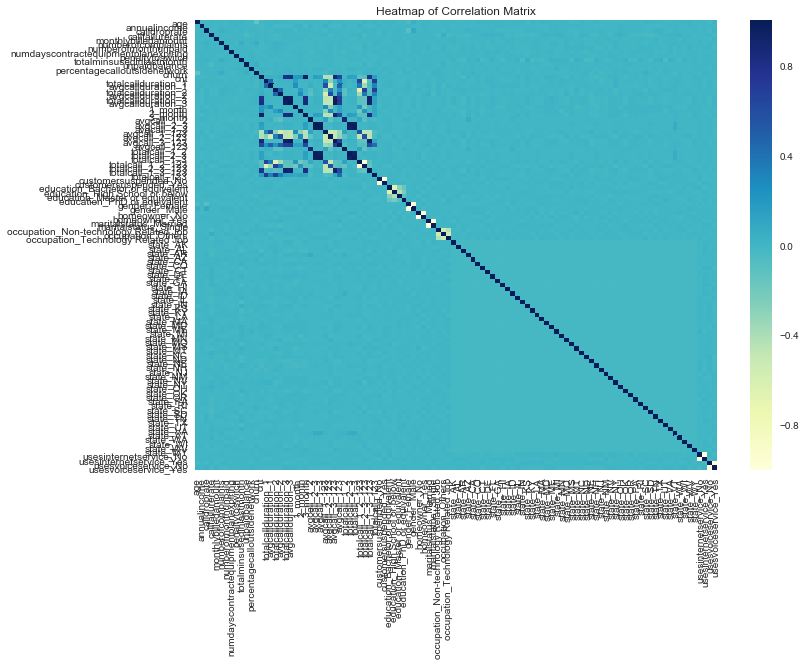

In [1499]:
corr = df.corr()
# plot heat map
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            ax = ax,
            cmap='YlGnBu')
plt.title('Heatmap of Correlation Matrix')

### Корреляции между признаками нет, есть только у тех фичей которые были нагенерены.

## MIX pandas Dataset

In [1500]:
df = df.sample(frac=1)

# X/y

In [1501]:
X = df.drop('churn', axis=1)
y = df.churn

# Train / Test

In [1502]:
from sklearn.cross_validation import train_test_split
X = df.drop('churn', axis=1)
y = df.churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12332,stratify=y)
N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print(N_train, N_test)

6667 2858


## Попробуем Бустинг

# XGBoost

In [1503]:
%pylab inline
from sklearn import ensemble, cross_validation, learning_curve, metrics 
xgb_classifier = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.1, learning_rate=0.05,
       max_delta_step=0, max_depth=5, min_child_weight=10, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=130, silent=True, subsample=0.7)

Populating the interactive namespace from numpy and matplotlib


In [1504]:
%%time
xgb_classifier.fit(X_train, y_train)

#all_pred = pd.DataFrame(np.vstack([y_test, pred])).T
#all_pred.columns = ['true', 'prob']
#all_pred = all_pred.sort_values('prob', ascending=False)
#round(np.shape(all_pred)[0]*10/100)
#pers, gain, lift = [], [], []

#for i in range(100):
#    i+=1
#    pers.append(i)
#    n=round(np.shape(all_pred)[0]*i/100)
#    #print(n)
#    g=sum(all_pred['true'].head(n))
#    #print(g)
#    gain.append(g)
#    g_base = sum(all_pred['true']) *i/100 
#    lift.append(g / g_base)

Wall time: 32.7 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.1, learning_rate=0.05,
       max_delta_step=0, max_depth=5, min_child_weight=10, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=130, silent=True, subsample=0.7)

In [1506]:
from sklearn.metrics import roc_auc_score
roc = roc_auc_score(y_test,xgb_classifier.predict_proba(X_test)[:,1] )
print(roc, ' - RocAuc')
print(2*roc-1, ' - Gini')

0.686627161598  - RocAuc
0.373254323196  - Gini


In [1507]:
from sklearn.metrics import confusion_matrix

In [1508]:
confusion_matrix(y_test, xgb_classifier.predict(X_test))

array([[2590,   10],
       [ 256,    2]], dtype=int64)

Text(0.5,1,'Lift-chart')

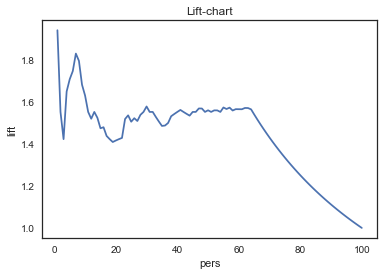

In [1509]:
plt.plot(pers, lift)
plt.xlabel('pers')
plt.ylabel('lift')
plt.title('Lift-chart')

In [1510]:
print(lift[0], ' - Лифт на одном проценте')
print(lift[1], ' - Лифт на двух процентах')
#print(lift[99])

1.93798449612  - Лифт на одном проценте
1.5503875969  - Лифт на двух процентах


#### Очень низкий показатель Лифта, т.е.обзвонив 1% из отсортированного списка = около 28 клиентов в которых исходя из генеральной совокупности должно находиться около 2-3 отточников мы получим всего 4-6 реальных отточника. Улучшим рандомный обзвон всего в два раза. Т.к. лифт = '1.9' Т.е. бустинг тут неэффективен.

# Feature Importance

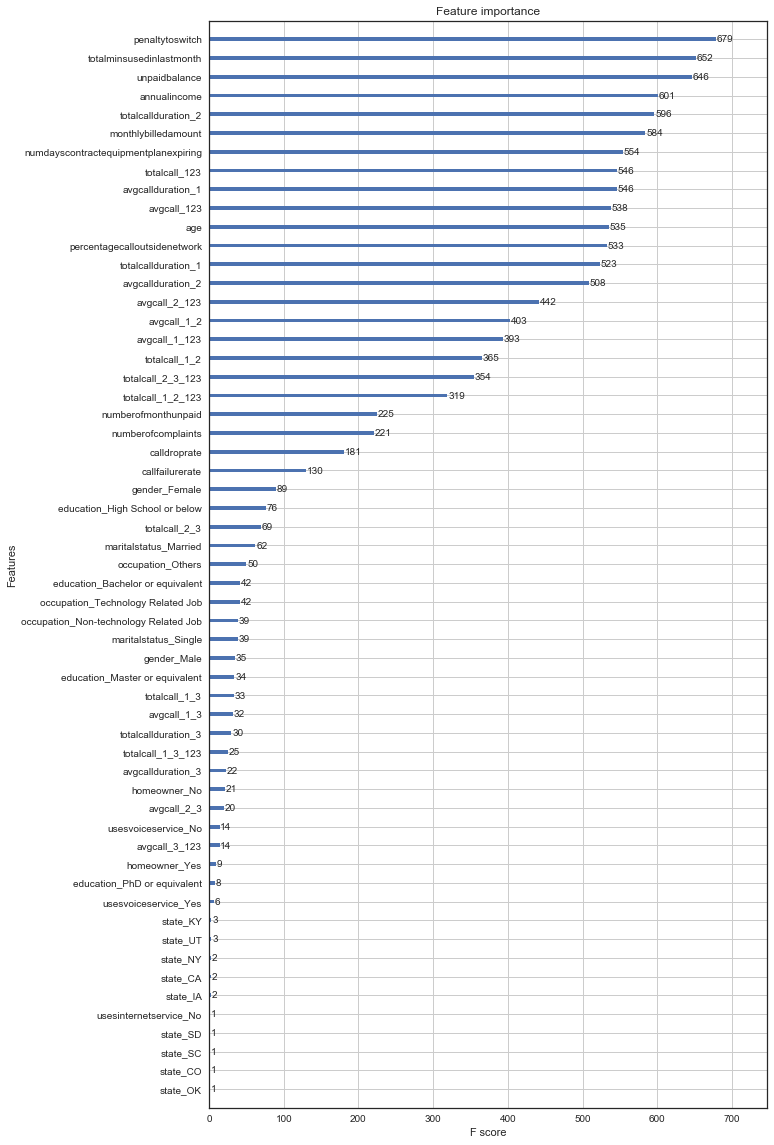

In [1511]:
# feature importance
from xgboost import plot_importance
from matplotlib import pyplot

#print(xgb_classifier.feature_importances_)
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

my_plot_importance(xgb_classifier,  figsize=(10,20))

# histogramm for scores

Text(0.5,1,'histogramm for scores')

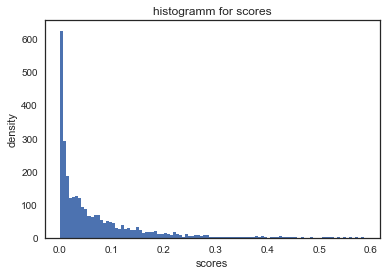

In [1512]:
import numpy as np
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
a= xgb_classifier.predict_proba(X_test)[:,1]
%matplotlib inline  
np.histogram(a.tolist(), bins=1000)
plt.hist(a, bins=100)
plt.xlabel('scores')
plt.ylabel('density')
plt.title('histogramm for scores')

In [1513]:
print (100*y_train.sum()/y_train.shape[0], ' - churn percent in train')
print (100*y_test.sum()/y_test.shape[0], ' - churn percent in train')

9.04454777261  - churn percent in train
9.02729181246  - churn percent in train


# Precision Recall / RocAuc

In [1514]:
import pandas as pd
import scipy
import sklearn
%matplotlib inline
import pandas as pd
import numpy as np
import os

# We'll also import seaborn, a Python graphing library
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)


from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.cross_validation import KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, auc

In [1515]:
def plot_curves(fpr, tpr, precision, recall):

    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall: AUC={0:0.3f}'.format(auc(recall, precision)))

    plt.subplot(122)
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: : AUC=%0.3f' % auc(fpr, tpr))
    plt.show()

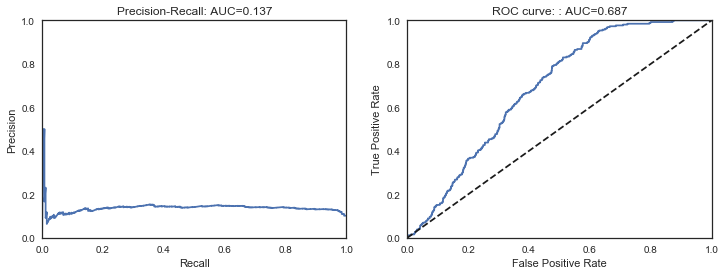

In [1516]:
pred =xgb_classifier.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, pred)
fpr, tpr, thresholds = roc_curve(y_test, pred)
plot_curves(fpr, tpr, precision, recall)

# Lift

In [1518]:
all_pred = pd.DataFrame(np.vstack([y_test, pred])).T
all_pred.columns = ['true', 'prob']
#all_pred.sort('prob', ascending=False, inplace=True)
all_pred = all_pred.sort_values('prob', ascending=False)
round(np.shape(all_pred)[0]*10/100)
pers, gain, lift = [], [], []

for i in range(100):
    i+=1
    pers.append(i)
    n=round(np.shape(all_pred)[0]*i/100)
    #print(n)
    g=sum(all_pred['true'].head(n))
    #print(g)
    gain.append(g)
    g_base = sum(all_pred['true']) *i/100 
    lift.append(g / g_base)
    #print(lift[i-1], ' - Lift on 1% percent')
print(lift[0], ' - Lift on 1% percent')

1.16279069767  - Lift on 1% percent


Text(0.5,1,'Lift-chart')

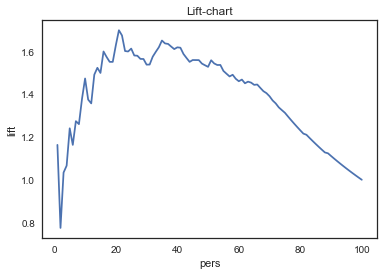

In [1519]:
plt.plot(pers, lift)
plt.xlabel('pers')
plt.ylabel('lift')
plt.title('Lift-chart')

Text(0.5,1,'gain-chart')

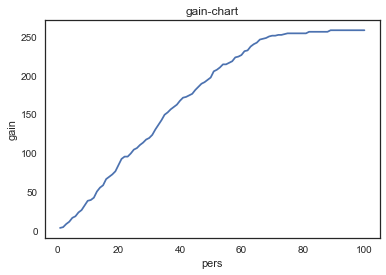

In [1520]:
plt.plot(pers, gain)
plt.xlabel('pers')
plt.ylabel('gain')
plt.title('gain-chart')

# Parameter's tuning

In [1021]:
model = xgb.XGBClassifier()

In [1022]:
model.get_xgb_params

<bound method XGBModel.get_xgb_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)>

In [1025]:
param_list = {'n_estimators' : [500,1000,1500], 
              'gamma':[i/10.0 for i in range(3,5)],
              'min_child_weight': [10, 20],
              'reg_alpha': [0],
              'learning_rate': [0.05, 0.15],
              'objective': ["reg:logistic"],
              "max_depth": [6],
              "subsample": [0.7],
              "colsample_bytree": [0.6],
              'seed': [130]
             }

In [1026]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
%%time
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_list, n_iter=10, scoring='roc_auc')
rsearch.fit(X, y)
print(rsearch)
# summarize the results of the random parameter search
print(rsearch.best_score_)

In [156]:
print(rsearch.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.1, learning_rate=0.05,
       max_delta_step=0, max_depth=6, min_child_weight=20, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=130, silent=True, subsample=0.7)


## Cross validation and learning curves

In [1028]:
%pylab inline

from sklearn import ensemble, cross_validation, learning_curve, metrics 

xgb_classifier = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.2, learning_rate=0.15, max_delta_step=0, max_depth=6,
       min_child_weight=8, missing=None, n_estimators=500, nthread=-1,
       objective='reg:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=130, silent=True, subsample=0.5)

train_sizes, train_scores, test_scores = learning_curve.learning_curve(xgb_classifier, X, y, 
                                                                       train_sizes=np.arange(0.1,1, 0.2), 
                                                                       cv=3, scoring='roc_auc')

Populating the interactive namespace from numpy and matplotlib


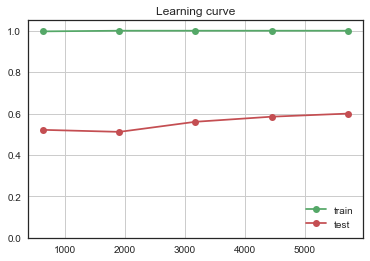

In [1029]:
pylab.grid(True)
pylab.plot(train_sizes, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
pylab.plot(train_sizes, test_scores.mean(axis = 1), 'r-', marker='o', label='test')
pylab.ylim((0.0, 1.05))
pylab.title("Learning curve")
pylab.legend(loc='lower right')

In [1034]:
xgb_classifier = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.1, learning_rate=0.05,
       max_delta_step=0, max_depth=3, min_child_weight=20, missing=None,
       n_estimators=500, n_jobs=1, nthread=None, objective='reg:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=130, silent=True, subsample=0.7)

In [1035]:
df.to_csv('FinalDs.csv')

In [1105]:
%%time
from sklearn.model_selection import cross_val_score
score =cross_val_score(xgb_classifier, X, y,  scoring = 'roc_auc', cv = 3)

Wall time: 1min 56s


In [1109]:
score

array([ 0.68596354,  0.68935497,  0.66733908])

#### Исходя из результатов кросс валидации - Модель стабильна, стабильна плоха

#### Попробуем случайный лес

# Random Forrest

In [1521]:
%%time

from sklearn.cross_validation import train_test_split
X = df.drop('churn', axis=1)
y = df.churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 245,stratify=y)
N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print(N_train, N_test)

from sklearn.metrics import roc_auc_score
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators=2000,criterion='gini',max_depth= 20, min_samples_leaf = 25, random_state=2, n_jobs=-1,class_weight='balanced')
rf.fit(X_train, y_train)
roc = roc_auc_score(y_test,rf.predict_proba(X_test)[:,1] )
print('Roc_Auc -', roc)

6667 2858
Roc_Auc - 0.690336911151
Wall time: 15 s


Text(0.5,1,'Lift-chart')

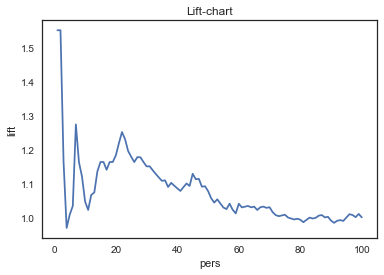

In [1522]:
all_pred = pd.DataFrame(np.vstack([y_test, pred])).T
all_pred.columns = ['true', 'prob']
#all_pred.sort('prob', ascending=False, inplace=True)
all_pred = all_pred.sort_values('prob', ascending=False)
round(np.shape(all_pred)[0]*10/100)
pers, gain, lift = [], [], []

for i in range(100):
    i+=1
    pers.append(i)
    n=round(np.shape(all_pred)[0]*i/100)
    g=sum(all_pred['true'].head(n))
    gain.append(g)
    g_base = sum(all_pred['true']) *i/100 
    lift.append(g / g_base)

plt.plot(pers, lift)
plt.xlabel('pers')
plt.ylabel('lift')
plt.title('Lift-chart')

In [1523]:
confusion_matrix(y_test, rf.predict(X_test))

array([[2388,  212],
       [ 225,   33]], dtype=int64)

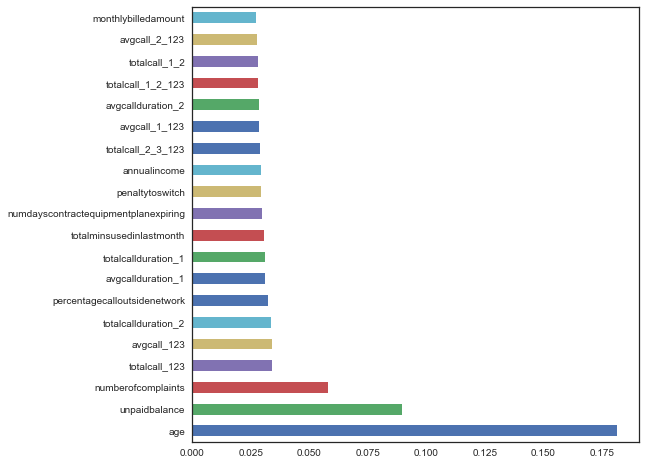

In [1524]:
plt.figure(figsize=(8,8))
pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20).plot(kind='barh')

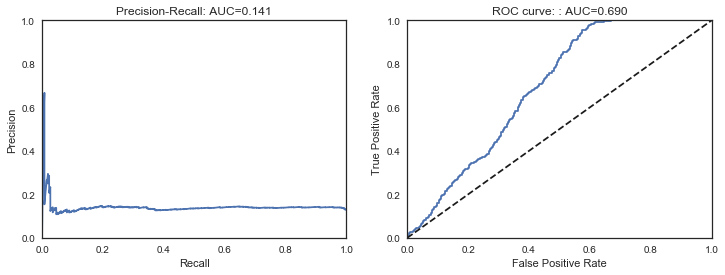

In [1525]:
pred =rf.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, pred)
fpr, tpr, thresholds = roc_curve(y_test, pred)
plot_curves(fpr, tpr, precision, recall)

# Lift

2.3255813953488373

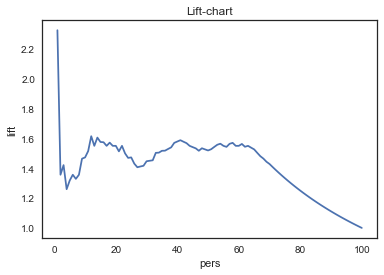

In [1526]:

all_pred = pd.DataFrame(np.vstack([y_test, pred])).T
all_pred.columns = ['true', 'prob']
#all_pred.sort('prob', ascending=False, inplace=True)
all_pred = all_pred.sort_values('prob', ascending=False)
round(np.shape(all_pred)[0]*10/100)
pers, gain, lift = [], [], []

for i in range(100):
    i+=1
    pers.append(i)
    n=round(np.shape(all_pred)[0]*i/100)
    g=sum(all_pred['true'].head(n))
    gain.append(g)
    g_base = sum(all_pred['true']) *i/100 
    lift.append(g / g_base)

plt.plot(pers, lift)
plt.xlabel('pers')
plt.ylabel('lift')
plt.title('Lift-chart')
lift[0]

Text(0.5,1,'gain-chart')

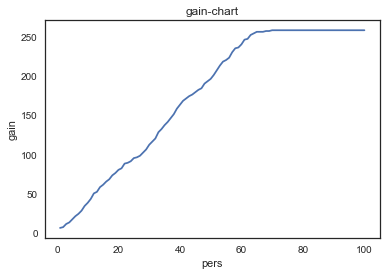

In [1527]:
plt.plot(pers, gain)
plt.xlabel('pers')
plt.ylabel('gain')
plt.title('gain-chart')

### Cross Validation

In [1528]:
%%time
from sklearn.model_selection import cross_val_score
score =cross_val_score(rf, X, y,  scoring = 'roc_auc', cv = 5)

Wall time: 1min 25s


In [1529]:
score

array([ 0.71096598,  0.67740778,  0.7134724 ,  0.67893423,  0.71692894])

#### Модель стабильна и стабильно имеет плохой лифт

In [1530]:
lift[0]

2.3255813953488373

### Проверим Лог регрессию

In [1445]:
#df['age'].mean()

In [1446]:
#df['age'].min()

In [1447]:
#df['age'].max()

In [1448]:
#df_norm.head()

## Logistic regression

## Normalize from 0 to 1

In [1451]:
df_norm = df / (df.max() - df.min())
df_norm.head()

,age,annualincome,calldroprate,callfailurerate,customersuspended,education,gender,homeowner,maritalstatus,monthlybilledamount,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,occupation,penaltytoswitch,state,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,churn,cnt,totalcallduration_1,avgcallduration_1,totalcallduration_2,avgcallduration_2,totalcallduration_3,avgcallduration_3,1_month,2_month,3_month,avgcall_1_2,avgcall_2_3,avgcall_1_3,avgcall_1_123,avgcall_2_123,avgcall_3_123,avgcall_123,totalcall_1_2,totalcall_2_3,totalcall_1_3,totalcall_1_2_123,totalcall_2_3_123,totalcall_1_3_123,totalcall_123
customerid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5500,0.447761,0.936044,0.714286,0.333333,0.0,0.000000,0.0,0.0,0.0,0.210084,0.666667,0.714286,0.515152,0.0,0.679359,0.938776,0.288577,0.184739,0.0,0.0,0.828283,0.0,1.0,0.196015,0.380952,0.219333,0.379720,0.0,0.0,1.0,1.0,0.0,0.001495,0.0,0.0,0.500460,0.499540,0.0,0.308019,0.000852,0.0,0.0,0.545971,0.454029,0.0,0.332020
439,0.985075,0.322450,0.000000,0.333333,0.0,0.333333,1.0,0.0,1.0,0.613445,1.000000,0.571429,0.313131,0.0,0.635271,0.489796,0.957916,0.257028,0.0,0.0,0.232323,0.0,1.0,0.283279,0.661064,0.268110,0.464336,0.0,0.0,1.0,1.0,0.0,0.002122,0.0,0.0,0.587065,0.412935,0.0,0.455653,0.001007,0.0,0.0,0.587065,0.412935,0.0,0.446245
1610,1.029851,0.437006,0.142857,1.000000,0.0,0.000000,1.0,1.0,1.0,0.126050,0.000000,0.285714,0.747475,1.0,0.076152,0.775510,0.513026,0.851406,0.0,0.0,0.000000,0.0,1.0,0.211859,0.494398,0.452717,0.559441,0.0,0.0,1.0,1.0,0.0,0.001317,0.0,0.0,0.468792,0.531208,0.0,0.426750,0.000446,0.0,0.0,0.386384,0.613616,0.0,0.507077
1401,0.820896,0.678806,0.000000,0.000000,0.0,0.333333,1.0,0.0,0.0,0.983193,1.000000,0.714286,0.272727,1.0,0.961924,0.714286,0.454910,0.799197,0.0,0.0,0.171717,0.0,1.0,0.290841,0.484594,0.033837,0.293007,0.0,0.0,1.0,1.0,0.0,0.002465,0.0,0.0,0.622862,0.377138,0.0,0.314820,0.008191,0.0,0.0,0.920418,0.079582,0.0,0.292224
5487,0.925373,0.878132,0.714286,0.333333,0.0,0.333333,1.0,0.0,1.0,0.462185,0.666667,0.714286,0.797980,0.5,0.943888,0.551020,0.492986,0.128514,0.0,0.0,0.363636,0.0,1.0,0.277278,0.539216,0.102641,0.888811,0.0,0.0,1.0,1.0,0.0,0.000904,0.0,0.0,0.377266,0.622734,0.0,0.578351,0.002574,0.0,0.0,0.784247,0.215753,0.0,0.326969


In [1462]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 
from sklearn.cross_validation import train_test_split

X = df.drop('churn', axis=1)
y = df.churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123,stratify=y)
N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print(N_train, N_test)

from sklearn.metrics import roc_auc_score
from sklearn import ensemble
lr = LogisticRegression(C = 0.3, penalty = 'l1')
lr.fit(X_train, y_train)
roc = roc_auc_score(y_test,lr.predict_proba(X_test)[:,1] )
print('Roc_Auc -', roc)
print (confusion_matrix(y_test, lr.predict(X_test)))

6667 2858
Roc_Auc - 0.659102564103
[[2599    1]
 [ 258    0]]
Wall time: 280 ms


## Выводы:
>1. Мы сменили структуру данных, присвоив каждому одному наблюдению одного клиента.
2. В итоге генерить мы могли только две переменные: avgcall, totalcall. т.к. остальные  значения для каждого месяца у одного абонента были одинаковы.
3. Соображения были следующие, поведение абонента уходящего в отток скорее всего имеет специфику снижения активности в течении последних месяцев. для этого я делил значения первого месяца на значения второго месяца и на значения третьего. Надеясь, что данные фичи дадут динамику. А также смотрел доли avgcall каждого из месяцев в общей сумме avgcall по всем месяцам.
4. также фичей был показатель количества наблюдений по одному абоненту. Как выяснилось у большинства абонентов этот показатель равен 2.
5. В качестве метрики я выбрал lift т.к. обычно при решении задачи оттока не требуются найти всех отточников, а тех, кто наиболее вероятнее всего уйдет. (Ведь если брать масштабы телекома, а это 60-70 млн абонентов, и проскорить всех абонентов, то у нас получится около полумилиона абонентов уходящих в отток с которыми поддерживать коммуникацию, дабы спасти их (предлагая скидку и т.д.) будет очень дорого для компании) Поэтому мы ищем только верхний 0.1% - 1% наиболее вероятных отточников.
6. Наиболее информативной переменной стал возраст. В целом видится динамика, что молодые люди чаще уходят в отток нежели люди после 40 лет.
7. Были построены три модели, наиболее качественной из которой получился случайный лес. Качественной на фоне остальных, но на общем фоне общее качество неприемлимо. Т.к. **ROC_AUC = 0.7** - это чуть лучше, чем ничего. И **lift(top1%) = 2- 3**, что примерно в 2 - 3 раза лучше рандомного обзвона верхнего 1% топа. 
8. Как бы я продолжил решать данную задачу далее?
>1. Занялся бы обогащением переменных. Добавил бы данные по трафику исходящему, входящему, лайтайм абонента. КОличество исходящих и входящих звонков, АРПУ за каждый месяц т.е. обогатить динамичными предикторами.
